In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from google.colab import files
import io

### **STEP 1: LOAD DATA**

In [25]:
try:
    # Try reading the file locally (if you uploaded it via the sidebar)
    print("Attempting to read 'VIW_FID_EPI.csv'...")
    df = pd.read_csv('VIW_FID_EPI.csv')
    print("File loaded successfully!")
except FileNotFoundError:
    # If not found, prompt the user to upload it
    print("File not found. Please upload 'VIW_FID_EPI.csv' now:")
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    df = pd.read_csv(io.BytesIO(uploaded[filename]))

Attempting to read 'VIW_FID_EPI.csv'...


/tmp/ipython-input-421229133.py:4: DtypeWarning: Columns (28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('VIW_FID_EPI.csv')


File loaded successfully!


In [26]:
# Convert date column to datetime objects
df['ISO_WEEKSTARTDATE'] = pd.to_datetime(df['ISO_WEEKSTARTDATE'])

### **STEP 2: PREPROCESSING**

In [27]:
# Filter for USA and Age Group 'All' (Total cases)
TARGET_COUNTRY = 'USA'

In [28]:
print(f"\nProcessing data for: {TARGET_COUNTRY}")
df_model = df[(df['COUNTRY_CODE'] == TARGET_COUNTRY) &
              (df['AGEGROUP_CODE'].isin(['All', 'ALL']))].copy()


Processing data for: USA


In [29]:
# Sort by date
df_model = df_model.sort_values('ISO_WEEKSTARTDATE')

In [30]:
# Keep only relevant columns
df_model = df_model[['ISO_WEEKSTARTDATE', 'ILI_CASE']]

In [31]:
# Handle Missing Values: Linear Interpolation for time series

df_model['ILI_CASE'] = df_model['ILI_CASE'].interpolate(method='linear')
df_model = df_model.dropna() # Drop any remaining NaNs at the very start

In [32]:
# Create "Lag Features" (Previous weeks' data to predict current week)
# We use the past 4 weeks (1 month) of data

for lag in range(1, 5):
    df_model[f'Lag_{lag}'] = df_model['ILI_CASE'].shift(lag)

In [33]:
df_model = df_model.dropna()

### **STEP 3: TRAIN/TEST SPLIT**

In [34]:
# We split by time, not randomly, to respect the order of events
train_size = int(len(df_model) * 0.8)
train = df_model.iloc[:train_size]
test = df_model.iloc[train_size:]

feature_cols = ['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4']
X_train = train[feature_cols]
y_train = train['ILI_CASE']
X_test = test[feature_cols]
y_test = test['ILI_CASE']

### **STEP 4: MODELING**

In [35]:
print("Training Random Forest Model...")
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

Training Random Forest Model...


RandomForestRegressor(random_state=42)

### **STEP 5: PREDICTION & EVALUATION**

In [36]:
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"\nModel Performance for {TARGET_COUNTRY}:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Model Performance for USA:
Mean Absolute Error (MAE): 13976.75
Root Mean Squared Error (RMSE): 28521.15


### **STEP 6: VISUALIZATION**

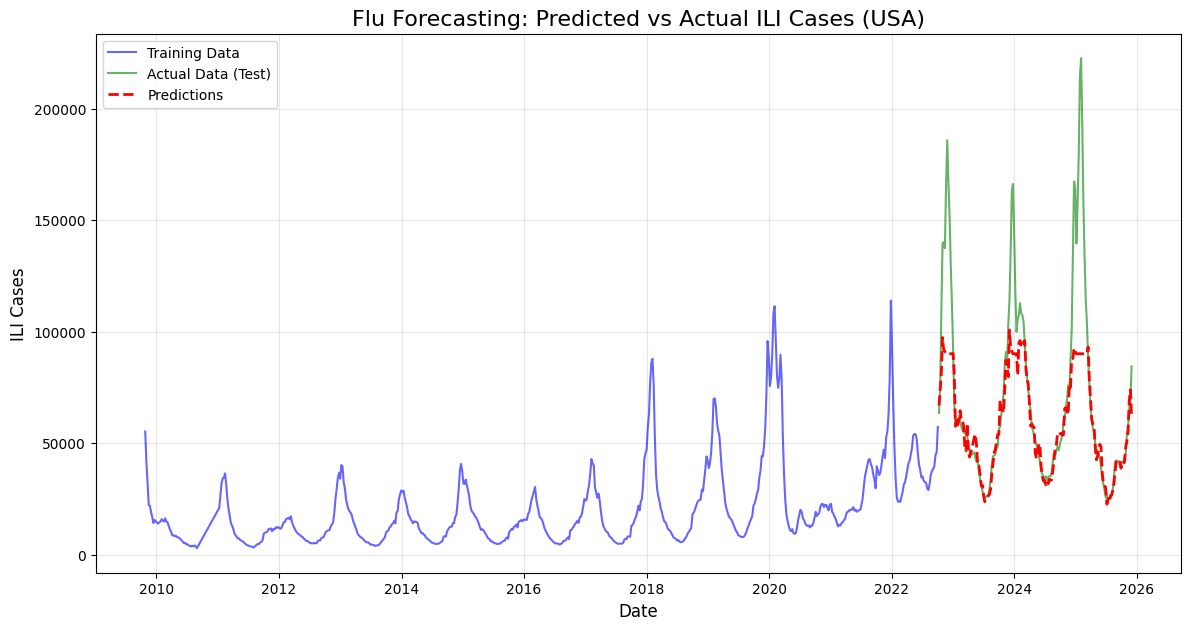

In [37]:
plt.figure(figsize=(14, 7))
plt.plot(train['ISO_WEEKSTARTDATE'], train['ILI_CASE'], label='Training Data', color='blue', alpha=0.6)
plt.plot(test['ISO_WEEKSTARTDATE'], test['ILI_CASE'], label='Actual Data (Test)', color='green', alpha=0.6)
plt.plot(test['ISO_WEEKSTARTDATE'], predictions, label='Predictions', color='red', linestyle='--', linewidth=2)

plt.title(f'Flu Forecasting: Predicted vs Actual ILI Cases ({TARGET_COUNTRY})', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('ILI Cases', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [38]:
# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

print(f"\nModel Accuracy Check:")
print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {100 - mape:.2f}%")


Model Accuracy Check:
MAPE: 12.66%
Accuracy: 87.34%
